# Navigation - Report

## 1. Implementation details
The implementation consists of files `agent.py`, `model.py` and `dqn_trainer.py` found under the `dql/` folder.
The code is organized as follows:

1. `agent.py` contains code for the agent.
2. `model.py` contains the neural network code that is used by the agent.
3. `dqn_trainer.py` contains code that is used to train the agent.

For information about the project and the environment can be found in the file [README.md](README.md)

## 2. Algorithm
A code template implementing the vanilla Deep Q-Learning from the Udacity course [Deep Reinforcement Learning](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) was used as the starting point of this project. This work extends the template by adding double Q-Learning and using dueling network architecture for the Q-networks.

### Learning process
The algorithm uses epsilon-greedy action selection policy to try out actions in the environment. At each step we add the observed state-action-reward-next_state tuple $(S, A, R, S')$ to the replay buffer (and remove the oldest experience if the buffer is already full).

At every `update_every` step we sample `minibatch_size` experiences from the replay buffer and use the experieces to update our Q-value approximation (neural network). In this work we used fixed Q-targets and Double Q-Learning to stabilize learning.

### Agent hyperparameters

| parameter                               | value |
|-----------------------------------------|-------|
| experience replay buffer size           | 1e5   |
| experience replay minibatch size        | 64    |
| gamma (discount factor)                 | 0.99  |
| tau (soft update factor)                | 1e-3  |
| lr (learning rate)                      | 5e-4  |
| update_every (update cycle for network) | 4     |


### Neural network architecture
The used neural network is a dueling neural network with fully connected layers. Specifically, we use 2 hidden layers with 64 and 128 hidden units respectively before feeding the outputs to the advantage (output dimension is the same as number of actions) and value (output dimension 1) streams. The final output is combined from the advantage and value streams by calculating

$$
Q(s,a) = V(s) + \big(A(s,a) - \frac{1}{|\mathcal{A}|}\sum_{a'} A(s,a')\big),
$$

for each state $s$ and action $a$.
This will be the Q-value of the state, up to a constant. This is because we subtract the mean advantage to fix identifiability of the model. See the Dueling networks paper for more details.




### Further reading

Deep Q-learning: [original paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

Double Q-Learning: [original paper](https://arxiv.org/pdf/1509.06461.pdf)

Dueling networks: [original paper](https://arxiv.org/pdf/1511.06581.pdf)

## 3. Training

Below, we show example of a training run of the algorithm and demonstrate we achieve the required score considered to solve the environment. For the training run, we chose to use CPU instead of GPU as the former had better performance in some simple timing tests that were run in the modeling phase. This is likely due to the simple structure of the neural net, where the additional parallel computing power from the GPU is not utilized fully.

If you want to watch a trained agent play, skip to part 4.

In [4]:
# imports
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from dql.agent import Agent
from dql.dqn_trainer import train_dqn

In [6]:
# get handle to the environment
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe", no_graphics=True)

# environment metadata
state_size = 37
action_size = 4

# create the agent
agent = Agent(state_size, action_size, seed=1234, use_gpu=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
# Train the agent for 1000 episodes
scores = train_dqn(agent, env, num_episodes=1000)

Episode 10	Average Score: -0.10
Episode 20	Average Score: 0.05
Episode 30	Average Score: 0.17
Episode 40	Average Score: 0.12
Episode 50	Average Score: 0.02
Episode 60	Average Score: 0.23
Episode 70	Average Score: 0.41
Episode 80	Average Score: 0.54
Episode 90	Average Score: 0.57
Episode 100	Average Score: 0.80
Episode 110	Average Score: 1.01
Episode 120	Average Score: 1.36
Episode 130	Average Score: 1.87
Episode 140	Average Score: 2.25
Episode 150	Average Score: 2.69
Episode 160	Average Score: 3.10
Episode 170	Average Score: 3.60
Episode 180	Average Score: 3.97
Episode 190	Average Score: 4.32
Episode 200	Average Score: 4.71
Episode 210	Average Score: 5.18
Episode 220	Average Score: 5.40
Episode 230	Average Score: 5.47
Episode 240	Average Score: 5.81
Episode 250	Average Score: 6.32
Episode 260	Average Score: 6.55
Episode 270	Average Score: 6.85
Episode 280	Average Score: 6.97
Episode 290	Average Score: 7.49
Episode 300	Average Score: 7.65
Episode 310	Average Score: 7.76
Episode 320	Aver

In [8]:
# save (local) network weights
torch.save(agent.dqn_local.state_dict(), 'dql/models/dueling_dqn_1000_iters.pth')

In [9]:
# close the environment
env.close()

### 3.1. Plot of training rewards

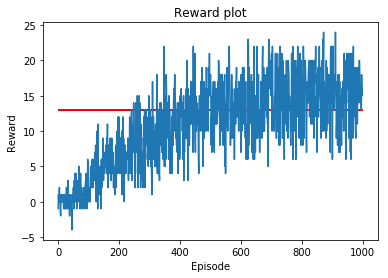

In [26]:
plt.plot(scores)
plt.hlines(y=13, xmin=0, xmax=1000, linewidth=2, color='r')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward plot")
plt.show()

The agent is considered to have solved the environment if the average reward on 100 consecutive episodes is over 13. This is accomplished the first time after roughly 530 iterations, and more reliably after 680 iterations.

## 4. Watch the agent play (with pretrained model)

In [17]:
# imports
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from dql.agent import Agent

# environment metadata
state_size = 37
action_size = 4

In [18]:
# create the agent
agent = Agent(state_size, action_size, seed=1234, use_gpu=False)

# load saved model weights
agent.dqn_local.load_state_dict(torch.load('dql/models/dueling_dqn_1000_iters.pth'))

In [19]:
# Watch agent play
import time

# get handle to the environment (with graphics)
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

# default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    time.sleep(float(0.1))
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
# close the env
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Score: 17.0


## 5. Future work

The algorithm could be improved for example by

1. Further tuning the hyperparameters and/or network architecture (number of hidden units/layers).
2. Implementing some algorithmic improvements such as

    i) Prioritized experience replay (see: [https://arxiv.org/pdf/1511.05952.pdf](https://arxiv.org/pdf/1511.05952.pdf)).
    
    ii) The rainbow algorithm (see: https://arxiv.org/pdf/1710.02298.pdf), or any of it's sub-extensions not yet mentioned (Multi-step learning, distributional RL, Noisy Nets).
 
3. Running the algorithm for more episodes (although we didn't get essentially better results with 2000 episodes). 
4. Not improvement as such, but additional challenge would be to learn the model straight from the pixel values. This would require more sophisticated network architecture likely utilizing convolutional neural nets.